In [1]:
%matplotlib inline

# Module 12 - Programming Assignment

## Directions

1. Change the name of this file to be your JHED id as in `jsmith299.ipynb`. Because sure you use your JHED ID (it's made out of your name and not your student id which is just letters and numbers).
2. Make sure the notebook you submit is cleanly and fully executed. I do not grade unexecuted notebooks.
3. Submit your notebook back in Blackboard where you downloaded this file.

*Provide the output **exactly** as requested*

# The Problem

When we last left our agent in Modules 1 and 11, it was wandering around a world filled with plains, forests, swamps, hills and mountains. This presupposes a map with known terrain:

```
......
...**.
...***
..^...
..~^..
```

but what if all we know is that we have some area of interest, that we've reduced to a GPS grid:

```
??????
??????
??????
??????
??????
```

and the agent has to determine what kind of terrain is to the left, front and right of it?

Assuming the agent has a very simple visual sensor that constructs a 4x4 grayscale image for each of the three directions, it might it could see something like this:

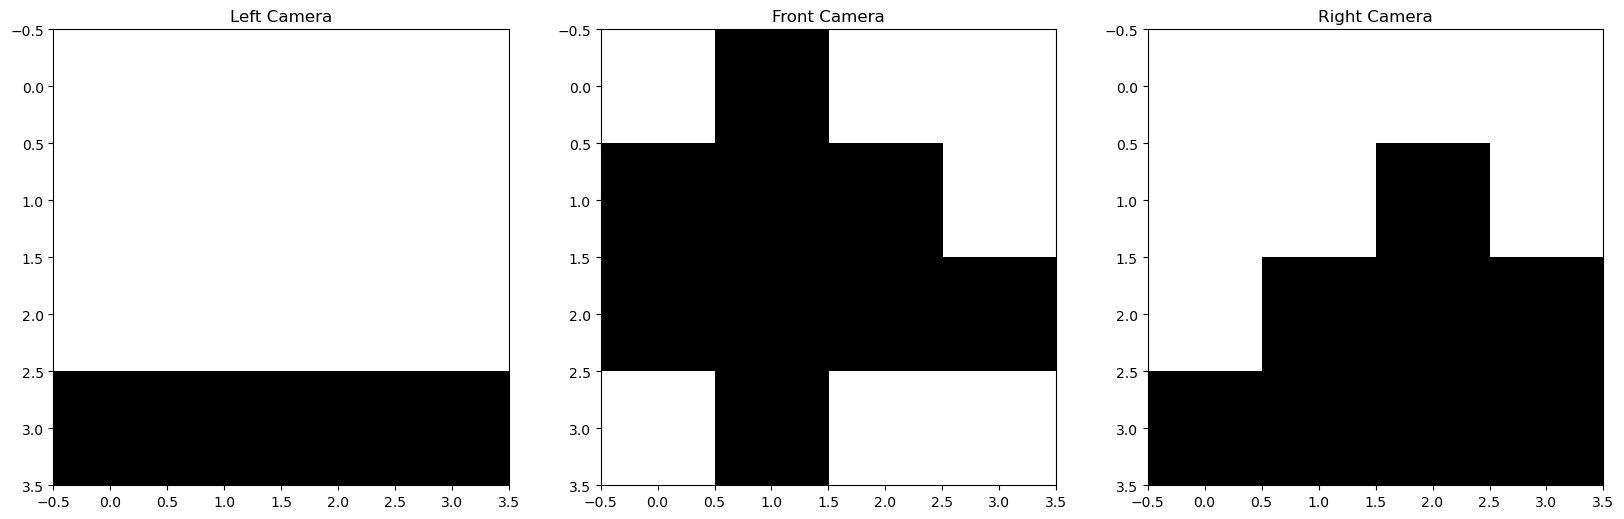

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

plain =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 1.0, 1.0, 1.0]
forest = [0.0, 1.0, 0.0, 0.0,1.0, 1.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0,0.0, 1.0, 0.0, 0.0]
hills =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 1.0, 0.0,0.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0]
swamp =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 0.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0]

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)
pixels = np.array([255 - p * 255 for p in plain], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Left Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 2)
pixels = np.array([255 - p * 255 for p in forest], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Front Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 3)
pixels = np.array([255 - p * 255 for p in hills], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Right Camera")
axes.imshow(pixels, cmap='gray')

plt.show()
plt.close()

which would be plains, forest and hills respectively.

## The Assignment

For this programming assignment your tasks are:

1. Write a logistic regression that simply determines if something is a hill or not (two class problem). 
2. You will also evaluate that logistic regression by generating a *confusion matrix*.

For a starting point, refer to the Pseudocode and the Self-Check.

## Data

We have clean examples of the different types of terrain but based on the location, the registration can be a bit off for some of the types and the visual sensor is often noisy.

Here are the clean examples with different registrations: 

In [3]:
clean_data = {
    "plains": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, "plains"]
    ],
    "forest": [
        [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, "forest"],
        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, "forest"]
    ],
    "hills": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, "hills"]
    ],
    "swamp": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "swamp"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, "swamp"]        
    ]
}

Let's create a function that allows us to view any of these:

In [4]:
def view_sensor_image(data):
    figure = plt.figure(figsize=(4,4))
    axes = figure.add_subplot(1, 1, 1)
    pixels = np.array([255 - p * 255 for p in data[:-1]], dtype='uint8')
    pixels = pixels.reshape((4, 4))
    axes.set_title( "Left Camera:" + data[-1])
    axes.imshow(pixels, cmap='gray')
    plt.show()
    plt.close()

"I think that I shall never see a thing so lovely as a tree."

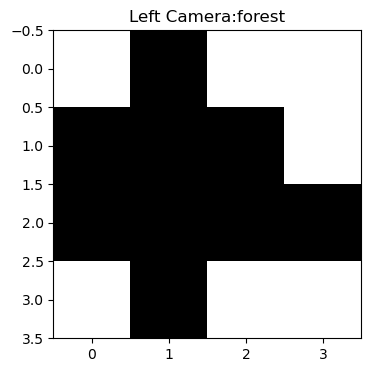

In [5]:
view_sensor_image( clean_data[ "forest"][0])

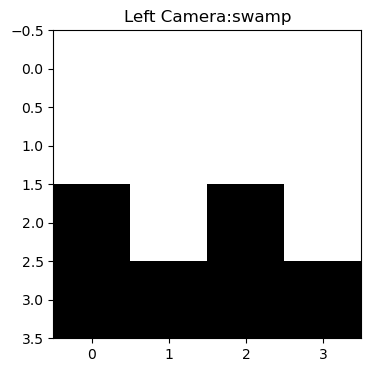

In [6]:
view_sensor_image( clean_data["swamp"][0])

The data that comes in, however, is noisy. The values are never exactly 0 and 1. In order to mimic this we need a `blur` function.

We will assume that noise is normally distributed. For values that should be 0, the noisy values are distributed $N(0.10, 0.05)$. For values should be 1, the noisy values are distributed $N(0.9, 0.10)$.

In [7]:
def blur( data):
    def apply_noise( value):
        if value < 0.5:
            v = random.gauss( 0.10, 0.05)
            if v < 0.0:
                return 0.0
            if v > 0.75:
                return 0.75
            return v
        else:
            v = random.gauss( 0.90, 0.10)
            if v < 0.25:
                return 0.25
            if v > 1.00:
                return 1.00
            return v
    noisy_readings = [apply_noise( v) for v in data[0:-1]]
    return noisy_readings + [data[-1]]

We can see how this affects what the agent *actually* sees.

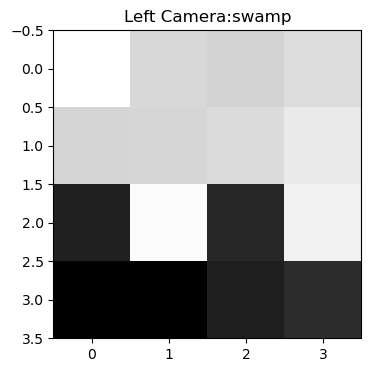

In [8]:
view_sensor_image( blur( clean_data["swamp"][0]))

We need four (4) functions:

1. `generate_data`
2. `learn_model`
3. `apply_model`
4. `evaluate`

### generate_data

`generate_data` has been written for you.

* clean_data - the clean versions of the "bitmaps" for each of the terrain types
* n - the number of samples for "in the class" (1) and "not in the class" (0) to generate.
* label - the label to chose as "in the class".

For example,

`generate_data( clean_data, 100, "hills")`

generates 100 hills, 100 not hills and has transformed the String labels into 1 and 0, respectively.

### `learn_model`

`learn_model` is the function that takes in training data and actually learns the logistic regression model. If you're up to it, you can implement a vectorized version using Numpy but you might start with the loopy version first.

*In the lecture, I mentioned that you usually should mean normalize your data but you don't need to do that in this case because the data is already on the range 0-1.*

I should also mention that gradient descent is not the usual approach to linear regression because the error function actually has an *exact* solution. However, in the case of large data sets, the exact solution often fails and in any case, the use of gradient descent will prepare you for neural networks next week.

When verbose is True, you should print out the error so you can see that it is getting smaller. 

When developing your algorithm, you need to watch the error so you'll set verbose=True to start. You should print it out every iteration and make sure it is declining. You'll have to experiment with both epsilon and alpha; and it doesn't hurt to make alpha adaptive (if the error increases, make alpha = alpha / 10).

When you know that your algorithm is working, change your code so that the error is printed out only every 1,000 iterations (it takes a lot of iterations for this problem to converge, depending on your parameter values--start early).

`learn_model` returns the List of Thetas.

### `apply_model`

`apply_model` takes a List of Thetas (the model) and either labeled or unlabeled data. If the data is unlabeled, it will return predictions for each observation as a Tuple of the inferred value (0 or 1) and the actual probability (so something like (1, 0.73) or (0, 0.29). We always return the class with the higher probability.

If the data are labeled, you will return a Tuple of the actual value (0 or 1) and the predicted value (0 or 1). In this case, you return a List of something like [(0, 1), (1, 1), (0, 0), (1, 0)].

### `evaluate`

Ideally, we should be running 10 fold cross validation on this problem but...that might take a while so we're going to just go ahead with a simple evaluation. We're interested not only in the error rate but the overall "confusion" of the model.

The `evaluate` takes the results of `apply_model` when labeled=True and prints out the error rate and a confusion matrix.

---

Why `labeled=True` or `labeled=False`? While we only have labeled data right now, for model evaluation. In the future, you would need to use this function to do actual classification. In that case, `labeled=False`. Because in the long run, that's the default usage, we use `False` as the default.

---

**As always when working with Lists or Lists of Lists, be very careful when you are modifying these items in place that this is what you want.**

In [9]:
import random
from copy import deepcopy
from math import exp, log10

# Helper Functions

## calculate_error

`calculate_error` is a helper function that computes the overall logarithmic error for a set of $\theta$ values. The function uses the below formula for logarithmic error:
$$ J(\theta) = \frac1n \sum_{i} y_i\log(\hat{y}_i) + (1 - y_i)\log(1 - \hat{y}_i) $$

where $i$ is the ith observation, $y_i$ is the label for the ith observation and $\hat{y}_i$ is the estimate for the ith observation from $$\hat{y} = \frac{1}{1 + e^{-\theta x}}$$
 
The error is used to determine the convergence of the `learn_model` function - after two successive iterations of the algorithm have an error difference of less than $\epsilon$, the algorithm terminates. **Used by**: [learn_model](#learn_model).

* **thetas**: a list of thetas for the current iteration of the model training
* **data**: the dataset as a list of feature-label tuples

**returns** `float`: the error for the thetas 

In [10]:
def calculate_error(thetas, data):
    J, num_features, n = 0, len(thetas), len(data)
    for obs, y in data:
        theta_x = sum(thetas[i]*obs[i] for i in range(num_features))
        y_hat = 1 / (1 + exp(-theta_x))
        J += (y*log10(y_hat)) if y_hat != 0 else 0
        J += (1 - y)*log10(1 - y_hat) if y_hat != 1 else 0
    return J / (-n) if n else 0

In [11]:
# assertions/unit tests
thetas = [0.8, 1.1]
test_data = [([1, 1.1], 0), ([1, 2.7], 1)]
err = calculate_error(thetas, test_data)
assert (err - 0.4687) < 0.0005

thetas = [1, 1]
test_data = [([1, 1], 1), ([2, 2], 0)]
err = calculate_error(thetas, test_data)
assert (err - 0.9) < 0.005

thetas = []
test_data = []
assert calculate_error(thetas, test_data) == 0

## derivative

`derivative` uses the below equation for the derivative of the error with respect to the jth $\theta$ value:

$$ \frac{\partial J}{\partial \theta_j} = \frac1n \sum_i (\hat{y}_i - y_i)x_{ij} $$

Here, $i$ represents the ith observation, and $j$ represents the jth feature in any observation. By multiplying the error of each observation by the jth feature's value, summing all terms and dividing by $n$, the function finds the weighted average of how the jth $\theta$ value impacts the overall error of the list of thetas. This is used to find how much to alter the jth $\theta$ value in the model training. **Used by**: [learn_model](#learn_model).

* **j**: the feature number to consider
* **thetas**: a list of theta values
* **data**: the input data

**returns** `float`: an increment to the jth $\theta$

In [12]:
def derivative(j, thetas, data):
    dJ, num_features, n = 0, len(thetas), len(data)
    for obs, label in data:
        theta_x = sum(thetas[i]*obs[i] for i in range(num_features))
        y_hat = 1 / (1 + exp(-theta_x))
        if j < num_features: dJ += (y_hat - label)*obs[j]
    return dJ / n

In [13]:
# assertions/unit tests
j = 0
thetas = [0.8, 1.1]
test_data = [([1, 1.1], 0), ([1, 2.7], 1)]
der = derivative(j, thetas, test_data)
assert (der - 0.4296) < 0.0005

j = 1
der = derivative(j, thetas, test_data)
assert (der - 0.4545) < 0.005

j = 2
der = derivative(j, thetas, test_data)
assert der == 0

# Main Functions

Use `generate_data` to generate a balanced set of blurred "hills" and "not-hills" examples to test that the function is working.

In [14]:
def generate_data( data, n, key_label):
    labels = list(data.keys())
    labels.remove(key_label)

    total_labels = len(labels)
    result = []
    # create n "not label" and code as y=0
    count = 1
    while count <= n:
        label = labels[count % total_labels]
        datum = blur(random.choice(data[label]))
        xs = datum[0:-1]
        result.append((xs, 0))
        count += 1

    # create n "label" and code as y=1
    for _ in range(n):
        datum = blur(random.choice(data[key_label]))
        xs = datum[0:-1]
        result.append((xs, 1))
    random.shuffle(result)
    return result

In [15]:
results = generate_data( clean_data, 10, "hills")
for result in results:
    print(result)

([0.136491020239013, 0.051566327167822994, 0.09079261579311274, 0.14354120194231887, 0.06755536124078346, 0.09811864923195947, 0.9094028302736057, 0.0425565576635055, 0.1750935078773465, 0.9609082872014415, 1.0, 0.9209004765248938, 0.8873025703664678, 0.9515877745532488, 0.7928645868816417, 0.9319105025299056], 1)
([0.08298680750635727, 0.09751071468146202, 0.043054735268673705, 0.08307153465175211, 0.1600243543400815, 0.027472927741580208, 0.05209939924367367, 0.13565324570901366, 0.1089738741090663, 0.8604337040452346, 0.07226638712601312, 0.8294056626211154, 0.814750692244058, 0.9491681158594669, 0.8701353912233265, 0.93686314702201], 0)
([0.1801965558946287, 0.0, 0.13266917427576733, 0.10770956782002601, 0.11069139051488763, 0.11351850819848519, 0.09941480229677532, 0.07703192360912013, 0.0, 0.910388996152056, 0.0643004658297896, 0.9180845005060972, 0.804169026894125, 0.8507726259790966, 0.853797979958204, 0.9948163472754459], 0)
([0.07020343981965033, 0.15335233742820287, 0.105400

## learn_model

`learn_model` is the method by which we train using gradient descent in this logistic regression model. The function generates a list of thetas randomly, and iteratively improves upon them using gradient descent until two successive iterations have an error difference within the margin of error ($\epsilon = 1*10^{-7}$). Initially, the data is altered to prepend a value of 1 to each list of features - this is to standardize the implicit $x_0$ value to be 1, as discussed in lecture. 

The `alpha` value is found through iterative trials of the algorithm. Starting at 0.1, the value was divided by 10 if it resulted in increasing error values during the course of the gradient descent. If the error values were decreasing, but very slowly, the value was increased by multiplying by 5-10. The final value was found after approximately 5 such adjustments. **Uses**: [calculate_error](#calculate_error), [derivative](#derivative).

* **data**: the data as a list of tuples containing features and labels
* **verbose**: an optional parameter to control whether error values are displayed

**returns** `List`: the final list of $\theta$ values after convergence is reached

In [16]:
def learn_model(data, verbose=False):
    thetas = [random.uniform(-1, 1) for i in range(len(data[0][0]) + 1)]
    new_data = [([1] + obs, label) for obs, label in deepcopy(data)]
    epsilon, alpha, t = 1e-7, 100, 0
    prev_err, curr_err = 0.0, calculate_error(thetas, new_data)
    while abs(curr_err - prev_err) > epsilon:
        t += 1; new_thetas = [0] * len(thetas)
        for j in range(len(thetas)):
            new_thetas[j] = thetas[j] - alpha * derivative(j, thetas, new_data)
        thetas = new_thetas
        prev_err = curr_err
        curr_err = calculate_error(thetas, new_data)
        if verbose: print("Current Error:", curr_err)
    return thetas

## apply_model

`apply_model` takes a list of $\theta$ values (`model`), the dataset, and an optional flag denoting whether data is labeled or not. The function returns a list of results whose format depends on the `labeled` flag.

If the data is labeled, the estimate label is returned in a tuple along with the actual label: `(actual, estimate)`. If the value of $\hat{y}$ is greater than 0.5, the estimate is 1 - otherwise, it is 0. 

If the data is unlabeled, the estimate value of $\hat{y}$ is returned along with the estimate label: `(label, value)`. For this application, all data will be labeled, but in future applications, there may be uses for this function on unlabeled datasets. 

* **model**: the list of theta values used as the model to find $\hat{y}$ for each observation
* **test_data**: the test data to apply the model to
* **labeled**: an optional parameter denoting whether data is labeled or not

**returns** `List`: a list of tuples that denote estimate labels

In [17]:
def apply_model(model, test_data, labeled=False):
    num_features = len(model)
    results = []
    if labeled:
        new_data = [([1] + obs, label) for obs, label in deepcopy(test_data)]
        for obs, label in new_data:
            theta_x = sum(model[i]*obs[i] for i in range(num_features))
            y_hat = 1 / (1 + exp(-theta_x))
            results.append((label, 1)) if y_hat >= 0.5 else results.append((label, 0))
    else:
        new_data = [([1] + obs) for obs in deepcopy(test_data)]
        for obs in new_data:
            theta_x = sum(model[i]*obs[i] for i in range(num_features))
            y_hat = 1 / (1 + exp(-theta_x))
            results.append((1, y_hat)) if y_hat >= 0.5 else results.append((0, y_hat))
    return results

## evaluate

`evaluate` takes a list of results from `apply_model`'s labeled output and computes the error rate and the confusion matrix. The function calculates true positive, false positive, true negative, and false negative counts based on the actual label and estimate labels. The error rate is computed as the count of false negatives and positives over the total count of observations: $$err = \frac{fn + fp}{n}$$

The confusion matrix is a 2x2 matrix, with the rows as estimate positive/negative observations, and the columns as actual positive/negative observations. For example, [0, 0] refers to the observation count where the actual observation was positive and the estimate was also positive (both were 1). In contrast, [0, 1] refers to observations where the actual observation was negative (0) and the estimate was positive (1).

* **results**: a list of tuples with actual and estimate observation labels

**returns** `None`: the function prints the error rate and confusion matrix as a side effect

In [18]:
def evaluate(results):
    tn, fn, tp, fp = 0, 0, 0, 0
    for actual, estimate in results:
        if actual:
            if estimate: tp += 1
            else: fp += 1
        else:
            if estimate: fn += 1
            else: tn += 1
    print("Error Rate:", ((fn + fp) / len(results)))
    print("--- Confusion Matrix ---")
    print("    |   A+   |   A-   ")
    print("E+  |  ",tp,"  |  ", fp)
    print("E-  |  ",fn,"  |  ", tn)
    return None

# Use your code

Use `generate_data` to generate 100 blurred "hills" examples balanced with 100 "non hills" examples and use this as your test data. Set labeled=True. Print out the first 10 results, one per line.

In [19]:
train_data = generate_data(clean_data, 100, "hills")

In [20]:
test_data = generate_data(clean_data, 100, "hills")

Use `learn_model` to learn a logistic regression model for classifying sensor images as "hills" or "not hills". Use your `generate_data` function to generate a training set of size 100 for "hills". **Set Verbose to True**

In [21]:
model = learn_model( train_data, True)

Current Error: -0.0
Current Error: 20.051764621237247
Current Error: -0.0
Current Error: 11.753123701344164
Current Error: -0.0
Current Error: 3.4545963431020668
Current Error: -0.0
Current Error: 1.2384964543283452
Current Error: 18.803601917170422
Current Error: -0.0
Current Error: 10.504960997277333
Current Error: -0.0
Current Error: 2.31668637331072
Current Error: -0.0
Current Error: 2.9877701494768543
Current Error: -0.0
Current Error: 0.5213584903636073
Current Error: 1.4634503308688018
Current Error: 16.585867139695747
Current Error: -0.0
Current Error: 8.287226221569602
Current Error: -0.0
Current Error: 1.0357727593299892
Current Error: 1.9913291557894324
Current Error: 21.347398047703695
Current Error: 0.180753837595432
Current Error: 13.048757127806404
Current Error: -0.0
Current Error: 4.815732358657888
Current Error: -0.0
Current Error: 1.4933907252831122
Current Error: 0.8965513462772701
Current Error: 14.851788639368792
Current Error: 0.22575607358169691
Current Error: 6

Current Error: 0.007612489877991022
Current Error: 0.012775439349558547
Current Error: 0.0075031157375443904
Current Error: 0.012423694709041214
Current Error: 0.007388783183074554
Current Error: 0.01206220431371064
Current Error: 0.007268598397697845
Current Error: 0.011689615270235177
Current Error: 0.007141381409099779
Current Error: 0.011303972230649405
Current Error: 0.007005498318334775
Current Error: 0.010902403970398811
Current Error: 0.0068587145246277546
Current Error: 0.010480875894621733
Current Error: 0.0066979833608461145
Current Error: 0.010033823849432813
Current Error: 0.006519030695744804
Current Error: 0.00955340143996923
Current Error: 0.00631556305067448
Current Error: 0.00902805437614156
Current Error: 0.006077840281463849
Current Error: 0.008440058700216285
Current Error: 0.0057901394768070606
Current Error: 0.0077615109005994
Current Error: 0.005426320170242547
Current Error: 0.00694857559457021
Current Error: 0.0049429694323069725
Current Error: 0.0059376421467

Current Error: 0.0009632038112447499
Current Error: 0.0009614202842365916
Current Error: 0.0009596433729078852
Current Error: 0.0009578730404203529
Current Error: 0.000956109250209057
Current Error: 0.0009543519659800167
Current Error: 0.0009526011517074064
Current Error: 0.0009508567716313435
Current Error: 0.0009491187902553259
Current Error: 0.0009473871723438513
Current Error: 0.0009456618829199712
Current Error: 0.0009439428872628908
Current Error: 0.0009422301509058233
Current Error: 0.000940523639633387
Current Error: 0.000938823319479527
Current Error: 0.0009371291567251604
Current Error: 0.0009354411178959639
Current Error: 0.0009337591697601566
Current Error: 0.0009320832793262665
Current Error: 0.0009304134138409506
Current Error: 0.0009287495407869967
Current Error: 0.0009270916278809668
Current Error: 0.0009254396430712745
Current Error: 0.0009237935545360876
Current Error: 0.0009221533306811608
Current Error: 0.000920518940137922
Current Error: 0.0009188903517614316
Curre

Current Error: 0.0006727402315785319
Current Error: 0.0006718713493309631
Current Error: 0.0006710047125872676
Current Error: 0.0006701403126359471
Current Error: 0.0006692781408105991
Current Error: 0.0006684181884895974
Current Error: 0.0006675604470958081
Current Error: 0.0006667049080963695
Current Error: 0.0006658515630022841
Current Error: 0.0006650004033682406
Current Error: 0.0006641514207922591
Current Error: 0.000663304606915496
Current Error: 0.0006624599534218485
Current Error: 0.0006616174520377983
Current Error: 0.0006607770945321244
Current Error: 0.0006599388727155382
Current Error: 0.0006591027784404798
Current Error: 0.0006582688036009452
Current Error: 0.000657436940131982
Current Error: 0.0006566071800096975
Current Error: 0.0006557795152507994
Current Error: 0.0006549539379124559
Current Error: 0.0006541304400919964
Current Error: 0.0006533090139266246
Current Error: 0.0006524896515932571
Current Error: 0.0006516723453081772
Current Error: 0.000650857087326834
Curr

Current Error: 0.0005139502271116965
Current Error: 0.0005134432932846399
Current Error: 0.0005129373592547011
Current Error: 0.0005124324220632949
Current Error: 0.0005119284787634462
Current Error: 0.0005114255264198925
Current Error: 0.0005109235621088794
Current Error: 0.0005104225829181301
Current Error: 0.0005099225859468889
Current Error: 0.0005094235683057113
Current Error: 0.0005089255271165814
Current Error: 0.0005084284595127258
Current Error: 0.0005079323626385573
Current Error: 0.0005074372336496925
Current Error: 0.0005069430697128744
Current Error: 0.0005064498680059236
Current Error: 0.0005059576257175938
Current Error: 0.0005054663400476711
Current Error: 0.0005049760082067874
Current Error: 0.0005044866274165036
Current Error: 0.0005039981949090863
Current Error: 0.0005035107079275638
Current Error: 0.0005030241637257038
Current Error: 0.0005025385595678599
Current Error: 0.0005020538927290092
Current Error: 0.000501570160494619
Current Error: 0.0005010873601607105
Cu

Current Error: 0.0004215609550139554
Current Error: 0.00042121990142532427
Current Error: 0.00042087939937289097
Current Error: 0.0004205394475188564
Current Error: 0.0004202000445297165
Current Error: 0.00041986118907631043
Current Error: 0.0004195228798337493
Current Error: 0.00041918511548141304
Current Error: 0.0004188478947029754
Current Error: 0.00041851121618631336
Current Error: 0.0004181750786235583
Current Error: 0.00041783948071101183
Current Error: 0.0004175044211491835
Current Error: 0.0004171698986427591
Current Error: 0.0004168359119005947
Current Error: 0.00041650245963564613
Current Error: 0.00041616954056503623
Current Error: 0.0004158371534099673
Current Error: 0.0004155052968957148
Current Error: 0.00041517396975168235
Current Error: 0.0004148431707112763
Current Error: 0.00041451289851198396
Current Error: 0.0004141831518952807
Current Error: 0.0004138539296066928
Current Error: 0.0004135252303956976
Current Error: 0.0004131970530157759
Current Error: 0.00041286939

Current Error: 0.0003565982421390123
Current Error: 0.00035635418090334756
Current Error: 0.0003561104535110232
Current Error: 0.00035586705927728013
Current Error: 0.00035562399751916515
Current Error: 0.000355381267555634
Current Error: 0.0003551388687074899
Current Error: 0.00035489680029738674
Current Error: 0.000354655061649814
Current Error: 0.0003544136520911413
Current Error: 0.0003541725709495488
Current Error: 0.00035393181755502524
Current Error: 0.00035369139123942904
Current Error: 0.0003534512913363777
Current Error: 0.0003532115171813504
Current Error: 0.00035297206811159135
Current Error: 0.0003527329434661827
Current Error: 0.00035249414258595597
Current Error: 0.0003522556648135533
Current Error: 0.00035201750949339494
Current Error: 0.0003517796759716806
Current Error: 0.00035154216359632154
Current Error: 0.0003513049717170884
Current Error: 0.00035106809968543716
Current Error: 0.0003508315468545823
Current Error: 0.00035059531257950036
Current Error: 0.00035035939

Current Error: 0.0003099032541223005
Current Error: 0.00030971890409179097
Current Error: 0.0003095347732221588
Current Error: 0.00030935086112275677
Current Error: 0.0003091671674038341
Current Error: 0.00030898369167660204
Current Error: 0.0003088004335531635
Current Error: 0.000308617392646565
Current Error: 0.00030843456857076334
Current Error: 0.0003082519609406088
Current Error: 0.0003080695693719037
Current Error: 0.0003078873934813366
Current Error: 0.0003077054328864796
Current Error: 0.00030752368720586614
Current Error: 0.0003073421560588867
Current Error: 0.00030716083906583326
Current Error: 0.00030697973584791117
Current Error: 0.0003067988460272
Current Error: 0.0003066181692266932
Current Error: 0.0003064377050702466
Current Error: 0.0003062574531826188
Current Error: 0.0003060774131894651
Current Error: 0.00030589758471725944
Current Error: 0.0003057179673934348
Current Error: 0.00030553856084623523
Current Error: 0.00030535936470482515
Current Error: 0.000305180378599

Current Error: 0.0002700404843833176
Current Error: 0.0002699004915917527
Current Error: 0.0002697606438403332
Current Error: 0.0002696209409037493
Current Error: 0.0002694813825572029
Current Error: 0.00026934196857631305
Current Error: 0.00026920269873718943
Current Error: 0.00026906357281640357
Current Error: 0.0002689245905909799
Current Error: 0.00026878575183840735
Current Error: 0.00026864705633662374
Current Error: 0.00026850850386404894
Current Error: 0.0002683700941995476
Current Error: 0.00026823182712242303
Current Error: 0.00026809370241246994
Current Error: 0.0002679557198498913
Current Error: 0.00026781787921539244
Current Error: 0.00026768018029007796
Current Error: 0.00026754262285554406
Current Error: 0.00026740520669381546
Current Error: 0.00026726793158737084
Current Error: 0.00026713079731913224
Current Error: 0.0002669938036724531
Current Error: 0.0002668569504311753
Current Error: 0.00026672023737952453
Current Error: 0.00026658366430221993
Current Error: 0.00026

Current Error: 0.00024238154848708164
Current Error: 0.00024226875280406438
Current Error: 0.00024215606202881645
Current Error: 0.00024204347601505048
Current Error: 0.0002419309946167744
Current Error: 0.0002418186176882443
Current Error: 0.00024170634508399649
Current Error: 0.00024159417665884703
Current Error: 0.0002414821122678626
Current Error: 0.00024137015176638936
Current Error: 0.000241258295010048
Current Error: 0.00024114654185470956
Current Error: 0.00024103489215652443
Current Error: 0.00024092334577190745
Current Error: 0.00024081190255753734
Current Error: 0.00024070056237035755
Current Error: 0.0002405893250675812
Current Error: 0.00024047819050667318
Current Error: 0.00024036715854537156
Current Error: 0.00024025622904167798
Current Error: 0.00024014540185385045
Current Error: 0.00024003467684040783
Current Error: 0.00023992405386013126
Current Error: 0.00023981353277206978
Current Error: 0.00023970311343551998
Current Error: 0.00023959279571004414
Current Error: 0.0

Apply the model to the test data:

In [22]:
results = apply_model( model, test_data, True)

Using the results above, print out your error rate (as a percent) and the confusion matrix:

In [23]:
evaluate(results)

Error Rate: 0.02
--- Confusion Matrix ---
    |   A+   |   A-   
E+  |   97   |   3
E-  |   1   |   99


# Discussion

From the above confusion matrix, we can see that the model performs exceptionally well - the overall error rate is 0.02 (2%), and there are very few false observations in the confusion matrix - only 4 out of 200. This demonstrates the accuracy and correctness of our gradient descent algorithm for classifying images as hills and not hills.

## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.